In [7]:
import json
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import sgd


class Catch(object):
    def __init__(self, grid_size):
        self.grid_size = grid_size
        self.reset()

    def _update_state(self, action):
        """
        Input: action and states
        Ouput: new states and reward
        """
        state = self.state
        # 0 = left
        # 1 = right
        # 2 = down
        # 3 = up
        
        fy, fx, py, px, t, d = state
        
        old_d = abs(fx - px) + abs(fy - py)
        
        if action == 0:
            if px > 0:
                px -= 1
        if action == 1:
            if px < self.grid_size-1:
                px += 1
        if action == 2:
            if py > 0:
                py-= 1
        if action == 3:
            if py < self.grid_size-1:
                py += 1
                
        new_d = abs(fx - px) + abs(fy - py)
        
        out = np.array([fy, fx, py, px, t-1, old_d-new_d])
        self.state = out

    def _draw_state(self):
        im_size = (self.grid_size,)*2
        state = self.state
        canvas = np.zeros(im_size)
        canvas[state[0], state[1]] = 1  # draw fruit
        canvas[state[2], state[3]] = 0.5  # draw basket
        return canvas

    def _get_reward(self):
        fruit_y, fruit_x, player_y, player_x, t, d = self.state
        
        if fruit_x == player_x and fruit_y == player_y:
            return 1
        
        if d == 1:
            return 0.1
        
        if d == 0:
            return -0.1
        
        if d == -1:
            return -1


    def _is_over(self):
        fruit_y, fruit_x, player_y, player_x, t, d = self.state
        
        if t == 0:
            return True
        
        if fruit_x == player_x and fruit_y == player_y:
            return True
    
        return False

    def observe(self):
        canvas = self._draw_state()
        return canvas.reshape((1, -1))

    def act(self, action):
        self._update_state(action)
        reward = self._get_reward()
        game_over = self._is_over()
        return self.observe(), reward, game_over

    def reset(self):
        fruit_x = np.random.randint(0, self.grid_size-1)
        fruit_y = np.random.randint(0, self.grid_size-1)
        player_x = np.random.randint(0, self.grid_size-1)
        player_y = np.random.randint(0, self.grid_size-1)
        time = abs(fruit_x - player_x) + abs(fruit_y - player_y)
        time *= 2
        
        while abs(fruit_x - player_x) + abs(fruit_y - player_y) < self.grid_size/2:
            fruit_x = np.random.randint(0, self.grid_size-1)
            fruit_y = np.random.randint(0, self.grid_size-1)
            player_x = np.random.randint(0, self.grid_size-1)
            player_y = np.random.randint(0, self.grid_size-1)
            time = abs(fruit_x - player_x) + abs(fruit_y - player_y)
            time *= 2
            
        self.state = np.asarray([fruit_y, fruit_x, player_y, player_x, time, 0])


class ExperienceReplay(object):
    def __init__(self, max_memory=100, discount=.9):
        self.max_memory = max_memory
        self.memory = list()
        self.discount = discount

    def remember(self, states, game_over):
        # memory[i] = [[state_t, action_t, reward_t, state_t+1], game_over?]
        self.memory.append([states, game_over])
        if len(self.memory) > self.max_memory:
            del self.memory[0]

    def get_batch(self, model, batch_size=10):
        len_memory = len(self.memory)
        num_actions = model.output_shape[-1]
        env_dim = self.memory[0][0][0].shape[1]
        inputs = np.zeros((min(len_memory, batch_size), env_dim))
        targets = np.zeros((inputs.shape[0], num_actions))
        for i, idx in enumerate(np.random.randint(0, len_memory,
                                                  size=inputs.shape[0])):
            state_t, action_t, reward_t, state_tp1 = self.memory[idx][0]
            game_over = self.memory[idx][1]

            inputs[i:i+1] = state_t
            # There should be no target values for actions not taken.
            # Thou shalt not correct actions not taken #deep
            targets[i] = model.predict(state_t)[0]
            Q_sa = np.max(model.predict(state_tp1)[0])
            if game_over:  # if game_over is True
                targets[i, action_t] = reward_t
            else:
                # reward_t + gamma * max_a' Q(s', a')
                targets[i, action_t] = reward_t + self.discount * Q_sa
        return inputs, targets


if __name__ == "__main__":
    # parameters
    epsilon = .1  # exploration
    num_actions = 4  # [move_left, stay, move_right]
    epoch = 10000
    max_memory = 500
    hidden_size = 200
    batch_size = 50
    grid_size = 100

    model = Sequential()
    model.add(Dense(hidden_size, input_shape=(grid_size**2,), activation='relu'))
    model.add(Dense(hidden_size, activation='relu'))
    model.add(Dense(hidden_size, activation='relu'))
    model.add(Dense(num_actions))
    model.compile(sgd(lr=.02), "mse")

    # If you want to continue training from a previous model, just uncomment the line bellow
    # model.load_weights("model_100.h5")

    # Define environment/game
    env = Catch(grid_size)

    # Initialize experience replay object
    exp_replay = ExperienceReplay(max_memory=max_memory)

    # Train
    win_cnt = 0
    for e in range(epoch):
        loss = 0.
        env.reset()
        game_over = False
        # get initial input
        input_t = env.observe()

        while not game_over:
            input_tm1 = input_t
            # get next action
            if np.random.rand() <= epsilon:
                action = np.random.randint(0, num_actions, size=1)
            else:
                q = model.predict(input_tm1)
                action = np.argmax(q[0])

            # apply action, get rewards and new state
            input_t, reward, game_over = env.act(action)
            if reward == 1:
                win_cnt += 1

            # store experience
            exp_replay.remember([input_tm1, action, reward, input_t], game_over)

            # adapt model
            inputs, targets = exp_replay.get_batch(model, batch_size=batch_size)

            loss += model.train_on_batch(inputs, targets)
        print("Epoch {:03d}/999 | Loss {:.4f} | Win count {}".format(e, loss, win_cnt))

        # Save trained model weights and architecture, this will be used by the visualization code
        model.save_weights("model_100.h5", overwrite=True)
        with open("model_100.json", "w") as outfile:
            json.dump(model.to_json(), outfile)

Epoch 000/999 | Loss 10.1801 | Win count 0
Epoch 001/999 | Loss 6.1748 | Win count 0
Epoch 002/999 | Loss 7.1970 | Win count 0
Epoch 003/999 | Loss 6.6862 | Win count 0
Epoch 004/999 | Loss 6.3099 | Win count 0
Epoch 005/999 | Loss 5.1816 | Win count 0
Epoch 006/999 | Loss 7.7510 | Win count 0
Epoch 007/999 | Loss 3.5384 | Win count 0
Epoch 008/999 | Loss 4.4765 | Win count 0
Epoch 009/999 | Loss 3.6764 | Win count 0
Epoch 010/999 | Loss 9.8292 | Win count 0
Epoch 011/999 | Loss 4.9087 | Win count 0
Epoch 012/999 | Loss 6.0121 | Win count 0
Epoch 013/999 | Loss 11.0233 | Win count 0
Epoch 014/999 | Loss 5.8175 | Win count 0
Epoch 015/999 | Loss 10.8819 | Win count 0
Epoch 016/999 | Loss 11.9098 | Win count 0
Epoch 017/999 | Loss 5.8775 | Win count 0
Epoch 018/999 | Loss 8.0692 | Win count 0
Epoch 019/999 | Loss 7.1373 | Win count 0
Epoch 020/999 | Loss 8.6544 | Win count 0
Epoch 021/999 | Loss 8.1624 | Win count 0
Epoch 022/999 | Loss 5.4350 | Win count 0
Epoch 023/999 | Loss 5.7397 | 

KeyboardInterrupt: 

82
118

ValueError: Error when checking : expected dense_141_input to have shape (100,) but got array with shape (10000,)

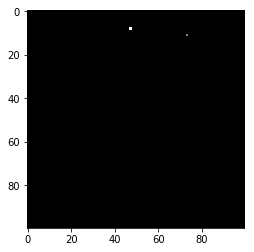

In [3]:
import json
import matplotlib.pyplot as plt
import numpy as np
from keras.models import model_from_json


if __name__ == "__main__":
    # Make sure this grid size matches the value used fro training
    grid_size = 100

    with open("model_100.json", "r") as jfile:
        model = model_from_json(json.load(jfile))
    model.load_weights("model_100.h5")
    model.compile("sgd", "mse")

    # Define environment, game
    env = Catch(grid_size)
    c = 0
    for e in range(10):
        loss = 0.
        env.reset()
        game_over = False
        # get initial input
        input_t = env.observe()

        plt.imshow(input_t.reshape((grid_size,)*2),
                   interpolation='none', cmap='gray')
        plt.savefig("%03d.png" % c)
        c += 1
        while not game_over:
            input_tm1 = input_t

            # get next action
            q = model.predict(input_tm1)
            action = np.argmax(q[0])

            # apply action, get rewards and new state
            input_t, reward, game_over = env.act(action)

            plt.imshow(input_t.reshape((grid_size,)*2),
                       interpolation='none', cmap='gray')
            plt.savefig("%03d.png" % c)
            c += 1

ffmpeg -i %03d.png output.gif -vf fps=1